In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

import torch
import pyro
from pyro import distributions as dist
from pyro.infer.mcmc import NUTS, MCMC
from pyro.infer.abstract_infer import EmpiricalMarginal, TracePredictive

In [2]:
data = pd.read_csv("input/data-outlier.txt")

In [3]:
data

,X,Y
0,1,3.4
1,2,8.2
2,3,40.0
3,4,17.6
4,5,20.3
5,6,23.2
6,7,28.5
7,8,32.7
8,9,36.6
9,10,39.7


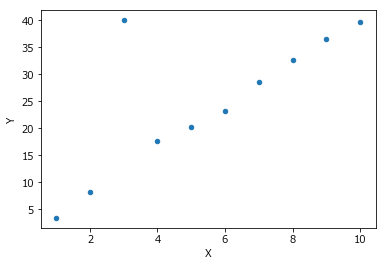

In [4]:
data.plot(kind='scatter', x="X", y="Y")

In [5]:
X = torch.tensor(data.X).float()
Y = torch.tensor(data.Y).float()

## モデル式

普通の単回帰

$Y[n] \sim Normal(a+b  X[n], \sigma)$

In [6]:
def model_normal(X, Y):
    a = pyro.sample("a", dist.Normal(0, 100))
    b = pyro.sample("b", dist.Normal(0, 100))
    sigma = pyro.sample("sigma", dist.Uniform(0, 100))
    
    mu = a + b * X
    with pyro.plate("data", len(X)):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=Y)

In [7]:
kernel = NUTS(model_normal, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
posterior = MCMC(kernel, num_chains=4, num_samples=1000, warmup_steps=2000).run(X, Y)

In [8]:
sites = ["a", "b", "sigma"]
marginal = pd.DataFrame(EmpiricalMarginal(posterior, sites)._get_samples_and_weights()[0].reshape(-1, len(sites)).numpy(), columns=sites)

In [9]:
marginal.quantile([0.025, 0.25, 0.5, 0.75, 0.975]).T

,0.025,0.25,0.5,0.75,0.975
a,-7.739239,2.792595,7.438158,12.027504,22.683473
b,0.669255,2.453828,3.212077,3.945361,5.600649
sigma,6.424147,8.349936,9.955454,12.261364,18.852946


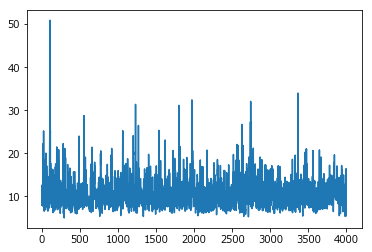

In [10]:
marginal.sigma.plot()

In [16]:
def pred_model_normal(X):
    a = pyro.sample("a", dist.Normal(0, 100))
    b = pyro.sample("b", dist.Normal(0, 100))
    sigma = pyro.sample("sigma", dist.Uniform(0, 100))
    
    mu = a + b * X
    pyro.sample("y", dist.Normal(mu, sigma))
predictive = TracePredictive(pred_model_normal, posterior, num_samples=1000).run(torch.arange(0, 12).float())
pred_samples = pd.DataFrame(EmpiricalMarginal(predictive, "y")._get_samples_and_weights()[0].numpy())

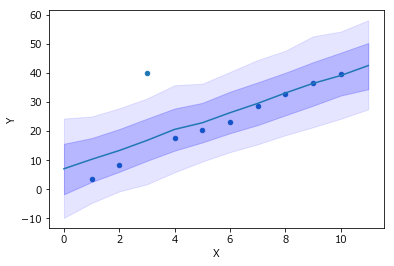

In [18]:
data.plot(kind='scatter', x="X", y="Y")
plt.plot(np.arange(0, 12), pred_samples.mean(0).values)
plt.fill_between(np.arange(0, 12), pred_samples.quantile(0.1).values, pred_samples.quantile(0.9).values, color='blue', alpha=0.1)
plt.fill_between(np.arange(0, 12), pred_samples.quantile(0.25).values, pred_samples.quantile(0.75).values, color='blue', alpha=0.2)

## モデル式

外れ値を考慮

$Y[n] \sim Cauchy(a+b  X[n], \sigma)$

In [6]:
def model_cauchy(X, Y):
    a = pyro.sample("a", dist.Normal(0, 100))
    b = pyro.sample("b", dist.Normal(0, 100))
    sigma = pyro.sample("sigma", dist.Uniform(0, 100))
    
    mu = a + b * X
    with pyro.plate("data", len(X)):
        pyro.sample("obs", dist.Cauchy(mu, sigma), obs=Y)

In [16]:
kernel_cauchy = NUTS(model_cauchy, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
posterior_cauchy = MCMC(kernel_cauchy, num_chains=4, num_samples=1000, warmup_steps=3000).run(X, Y)

In [17]:
sites = ["a", "b", "sigma"]
marginal_cauchy = pd.DataFrame(EmpiricalMarginal(posterior_cauchy, sites)._get_samples_and_weights()[0].reshape(-1, len(sites)).numpy(), columns=sites)

In [18]:
marginal_cauchy.quantile([0.025, 0.25, 0.5, 0.75, 0.975]).T

,0.025,0.25,0.5,0.75,0.975
a,-1.336640,-0.461577,-0.055157,0.414030,1.995874
b,3.770623,3.981071,4.059784,4.122577,4.260530
sigma,0.223366,0.469361,0.661475,0.929945,1.833240


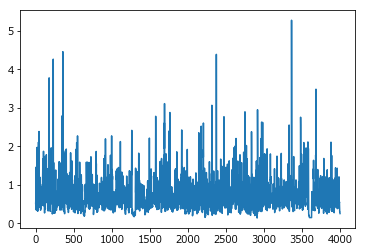

In [24]:
marginal_cauchy.sigma.plot()

In [43]:
def pred_model_cauchy(X):
    a = pyro.sample("a", dist.Normal(0, 100))
    b = pyro.sample("b", dist.Normal(0, 100))
    sigma = pyro.sample("sigma", dist.Uniform(0, 100))
    
    mu = a + b * X
    pyro.sample("y", dist.Cauchy(mu, sigma))
predictive_cauchy = TracePredictive(pred_model_cauchy, posterior_cauchy, num_samples=1000).run(torch.arange(0, 12, 0.1).float())
pred_samples_cauchy = pd.DataFrame(EmpiricalMarginal(predictive_cauchy, "y")._get_samples_and_weights()[0].numpy())

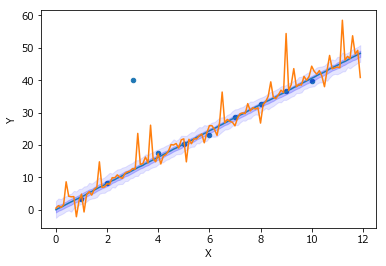

In [46]:
data.plot(kind='scatter', x="X", y="Y")
plt.plot(np.arange(0, 12, 0.1), pred_samples_cauchy.quantile(0.5).values)
plt.plot(np.arange(0, 12, 0.1), pred_samples_cauchy.mean(0).values)
plt.fill_between(np.arange(0, 12, 0.1), pred_samples_cauchy.quantile(0.1).values, pred_samples_cauchy.quantile(0.9).values, color='blue', alpha=0.1)
plt.fill_between(np.arange(0, 12, 0.1), pred_samples_cauchy.quantile(0.25).values, pred_samples_cauchy.quantile(0.75).values, color='blue', alpha=0.2)